In [1]:
#Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from wordcloud import WordCloud, STOPWORDS
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

In [2]:
#Set pandas options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
#Read file
GoogleAdwords = pd.read_csv('GoogleAdwordsClusters.csv')

In [4]:
#Reading the top rows of the data
GoogleAdwords.head()

,Unnamed: 0,Keyword,Competition,Local.Monthly.Searches,Approximate.CPC,KeyWord,Cost,Number.of.Letters,Number.of.Words,Clusters
0,1,party supplies paper,0.46,22200,$0.92,1,$20424.00,20,3,18
1,2,paper party supplies,0.46,22200,$0.96,1,$21312.00,20,3,18
2,3,party cups,0.77,14800,$1.13,1,$16724.00,10,2,4
3,4,party napkins,0.93,9900,$1.20,1,$11880.00,13,2,4
4,5,smarty had a party,0.41,6600,$0.31,1,$2046.00,18,4,65


In [5]:
#Drop old clusters column
GoogleAdwords = GoogleAdwords.drop(['Clusters'], axis = 1)

In [6]:
#Checking datatypes of all columns
GoogleAdwords.dtypes

Unnamed: 0                  int64
Keyword                    object
Competition               float64
Local.Monthly.Searches      int64
Approximate.CPC            object
KeyWord                     int64
Cost                       object
Number.of.Letters           int64
Number.of.Words             int64
dtype: object

In [7]:
#Performing necessary cleaning
GoogleAdwords['Approximate.CPC'] = GoogleAdwords['Approximate.CPC'].str.replace('$','')
GoogleAdwords['Approximate.CPC'] = pd.to_numeric(GoogleAdwords['Approximate.CPC'])

In [8]:
#Create a list of words that are critical in these Keyword searches
WordList = ['party', 'plastic', 'supplies', 'partyware', 'party ware', 'elegant', 'paper', 'disposable']

<h3> STEP 1: New Binary variables are created such as: <br>
'party', 'plastic', 'supplies', 'partyware', 'party ware', 'elegant', 'paper', 'disposable', <br> <br>

These have been included and they indicate whether that particular keyword phrase contains this word or not. For e.g, 'smarty had a party' contains the word 'party', so the 'party' value would be given a value of 1. </h3>

In [10]:
#Initialize new dictionary to later convert to a dataframe of columns of the above words and values indicating whether the word exists in the column or not
NewDict = {}
for word in WordList:
    NewDict[word] = []

for phrase in GoogleAdwords['Keyword']:
    for word in WordList:
        if word in phrase:
            NewDict[word].append(1)
        else:
            NewDict[word].append(0)

NewData = pd.DataFrame(NewDict)
NewData.head()

,party,plastic,supplies,partyware,party ware,elegant,paper,disposable
0,1,0,1,0,0,0,1,0
1,1,0,1,0,0,0,1,0
2,1,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0


In [12]:
#NewData of indicating the words exist in the phrases or not, is merged with original dataset
GoogleAdwordsNewData = pd.concat([GoogleAdwords, NewData], axis = 1)
GoogleAdwordsNewData.head()

,Unnamed: 0,Keyword,Competition,Local.Monthly.Searches,Approximate.CPC,KeyWord,Cost,Number.of.Letters,Number.of.Words,party,plastic,supplies,partyware,party ware,elegant,paper,disposable
0,1,party supplies paper,0.46,22200,0.92,1,$20424.00,20,3,1,0,1,0,0,0,1,0
1,2,paper party supplies,0.46,22200,0.96,1,$21312.00,20,3,1,0,1,0,0,0,1,0
2,3,party cups,0.77,14800,1.13,1,$16724.00,10,2,1,0,0,0,0,0,0,0
3,4,party napkins,0.93,9900,1.20,1,$11880.00,13,2,1,0,0,0,0,0,0,0
4,5,smarty had a party,0.41,6600,0.31,1,$2046.00,18,4,1,0,0,0,0,0,0,0


In [13]:
#Create New Data and taking only the x variables which I will be using in the model
GoogleAdwordsNewDataSubset = pd.concat([GoogleAdwordsNewData.iloc[:,2:5], GoogleAdwordsNewData.iloc[:,7:]], axis = 1)
GoogleAdwordsNewDataSubset.describe()

,Competition,Local.Monthly.Searches,Approximate.CPC,Number.of.Letters,Number.of.Words,party,plastic,supplies,partyware,party ware,elegant,paper,disposable
count,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000
mean,0.950923,434.723154,1.144698,26.766779,3.172819,0.261745,0.302013,0.080537,0.010067,0.010067,0.040268,0.082215,0.513423
std,0.073317,1738.842780,0.271681,4.628117,0.451328,0.439954,0.459517,0.272351,0.099913,0.099913,0.196753,0.274922,0.500240
min,0.330000,0.000000,0.300000,10.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.940000,16.000000,0.980000,24.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.970000,36.000000,1.110000,27.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.990000,140.000000,1.250000,30.000000,3.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,22200.000000,2.400000,40.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


 <h3> STEP 2: Scaled down all the attributes used to between 0 and 1 </h3>

In [14]:
#Min Max scaling method applied to the data to ensure variables like Monthly Searches don't highly influence the model, since distance matrices are computed
scaler = MinMaxScaler()
scaledDF = scaler.fit_transform(GoogleAdwordsNewDataSubset)
NewScaledDF = pd.DataFrame(scaledDF, columns= GoogleAdwordsNewDataSubset.columns)
NewScaledDF.head()

,Competition,Local.Monthly.Searches,Approximate.CPC,Number.of.Letters,Number.of.Words,party,plastic,supplies,partyware,party ware,elegant,paper,disposable
0,0.194030,1.000000,0.295238,0.333333,0.333333,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.194030,1.000000,0.314286,0.333333,0.333333,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.656716,0.666667,0.395238,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.895522,0.445946,0.428571,0.100000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.119403,0.297297,0.004762,0.266667,0.666667,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<h3> STEP 3: Fit KMeans Clustering Model (10 clusters) </h3>

In [15]:
#Convert to numpy array to feed into to the KMeans model
X = NewScaledDF.values
KMeansModel = KMeans(n_clusters = 10, random_state = 20).fit(X)

In [16]:
#Add new column named 'Clusters' to the dataset
NewScaledDF['Clusters'] = KMeansModel.labels_

In [17]:
#Join this data with the original column of keywords
GoogleAdwordsClusteredData = pd.concat([GoogleAdwords['Keyword'],NewScaledDF], axis = 1)
GoogleAdwordsClusteredData.head()

,Keyword,Competition,Local.Monthly.Searches,Approximate.CPC,Number.of.Letters,Number.of.Words,party,plastic,supplies,partyware,party ware,elegant,paper,disposable,Clusters
0,party supplies paper,0.194030,1.000000,0.295238,0.333333,0.333333,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,8
1,paper party supplies,0.194030,1.000000,0.314286,0.333333,0.333333,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,8
2,party cups,0.656716,0.666667,0.395238,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,party napkins,0.895522,0.445946,0.428571,0.100000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,smarty had a party,0.119403,0.297297,0.004762,0.266667,0.666667,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


<h3> STEP 4: Plot Word Cloud for each of the clusters </h3>

In [18]:
#Cluster numbers from 1 to 10
clusterRange = range(1,10)

In [19]:
#Creat Word Cloud object
wc = WordCloud()

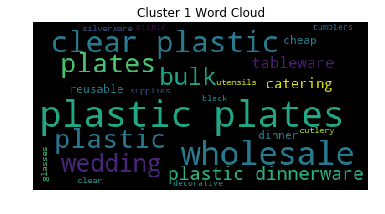

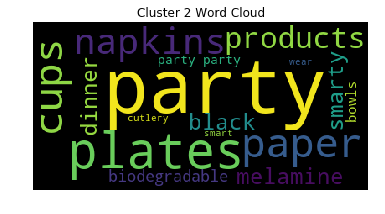

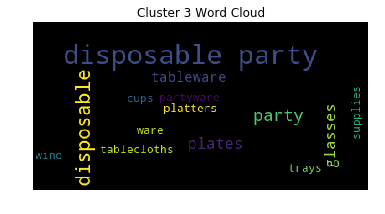

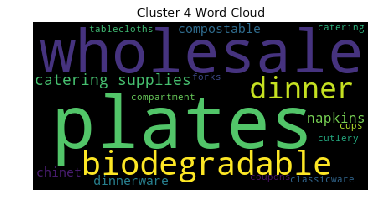

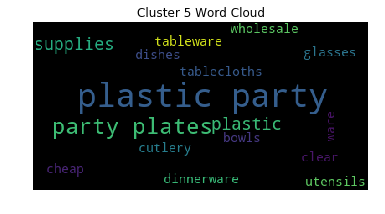

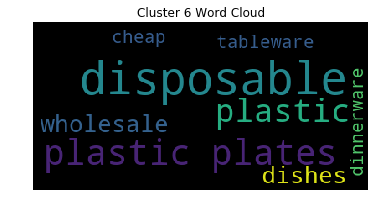

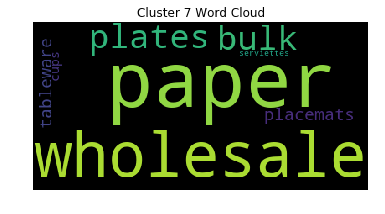

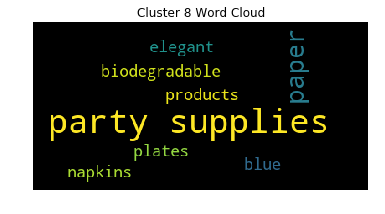

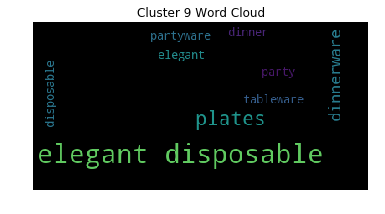

In [20]:
#Plot Word Clouds for each cluster
for clusterNumber in clusterRange:
    KeywordCluster = GoogleAdwordsClusteredData[GoogleAdwordsClusteredData['Clusters'] == clusterNumber]['Keyword']
    WordString = []
    for phrase in KeywordCluster:
        WordString.append(phrase)
    NewWordString = " ".join(WordString)
    basecloud = wc.generate(NewWordString)
    plt.imshow(basecloud)
    plt.axis('off')
    plt.title('Cluster ' + str(clusterNumber) + ' Word Cloud')
    plt.show()